# 5. 지도 학습: 회귀
- 지도 학습의 문제 → 회귀/분류 <br>
    - 회귀: 입력에 대해 연속적인 값 대응 <br>
    - 분류: 입력에 대해 순서가 없는 클래스(라벨) 대응

## 5.1 1차원 입력 직선 모델
$x_n$을 입력 변수, $t_n$을 목표 변수(대상)이라고 할 때 <br>
목표: 데이터베이스에 업슨 사람의 나이($x$)에 대해 그 사람의 키($t$) 예측하기

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 생성
np.random.seed(seed=1) # 난수 고정
X_min = 4 # X의 하한
X_max = 30 # X의 상한
X_n = 16 # X의 상한 (16개만 뽑도록 할 것)
X = 5 + 25 *np.random.rand(X_n)
Prm_c = [170, 108, 0.2] # 생성 매개 변수
T = Prm_c[0] - Prm_c[1] * np.exp(-Prm_c[2]*X) + 4 * np.random.randn(X_n) # (A) X에서 T를 결정
np.savez("ch5_data.npz", X=X, X_min=X_min, X_max=X_max, X_n=X_n, T=T) # (B) 데이터 저장

In [14]:
print(X)

[15.42555012 23.00811234  5.00285937 12.55831432  8.66889727  7.30846487
  9.65650528 13.63901818 14.91918686 18.47041835 15.47986286 22.13048751
 10.11130624 26.95293591  5.68468983 21.76168775]


In [15]:
print(np.round(X, 2))

[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]


In [16]:
print(np.round(T, 2))

[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


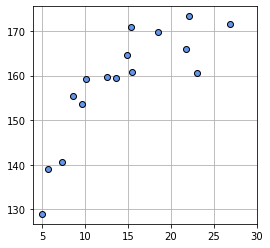

In [17]:
# 데이터 그래프
plt.figure(figsize=(4, 4))
plt.plot(X, T, marker="o", linestyle="None", markeredgecolor="black", color="cornflowerblue")
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

### 5.1.1 직선 모델

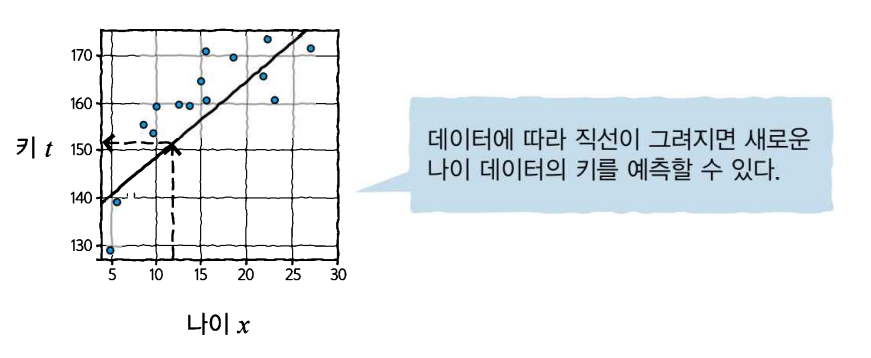
$$ y(x) = w_0x + w_1$$
위의 식을 직선 모델로 부르기로 함

### 5.1.2 제곱 오차 함수
오차 $J$(평균 제곱 오차)를 정의하면
$$ J = {1 \over N} \sum_{n=0}^{N-1}(y_n-t_n)^2 $$
$y_n$은 직선 모델에 $x_n$을 넣었을 때의 출력을 의미함
$$ y_n = y(x_n) = w_0x_n + w_1 $$

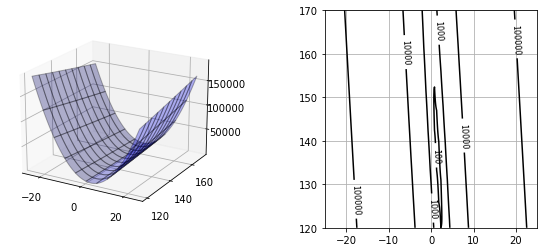

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# 평균 오차 함수
def mse_line(x, t, w):
    y = w[0] * x + w[1]
    mse = np.mean((y-t)**2)
    return mse

# 계산
xn = 100 # 등고선 표시 ㅐ상도
w0_range = [-25, 25]
w1_range = [120, 170]
x0 = np.linspace(w0_range[0], w0_range[1], xn)
x1 = np.linspace(w1_range[0], w1_range[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
J = np.zeros((len(x0), len(x1)))

for i0 in range(xn):
    for i1 in range(xn):
        J[i1, i0] = mse_line(X, T, (x0[i0], x1[i1]))
        
# 표시
plt.figure(figsize=(9.5, 4))
plt.subplots_adjust(wspace=0.5)

ax = plt.subplot(1, 2, 1, projection = "3d")
ax.plot_surface(xx0, xx1, J, rstride=10, cstride=10, alpha=0.3, color="blue", edgecolor="black")
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120, 140, 160])
ax.view_init(20, -60)

plt.subplot(1, 2, 2)
cont = plt.contour(xx0, xx1, J, 30, colors="black", levels=[100, 1000, 10000, 100000])
cont.clabel(fmt="%1.0f", fontsize=8)
plt.grid(True)
plt.show()

- $w$ 공간에서의 평균 제곱 오차 → 계곡과 같은 모양임을 확인 가능
- $w_0$ 방향의 변화에 $J$가 크게 변화함 (기울기가 바뀌면 직선이 데이터 점에서 어긋나서)

### 5.1.3 매개변수 구하기 (경사 하강법)
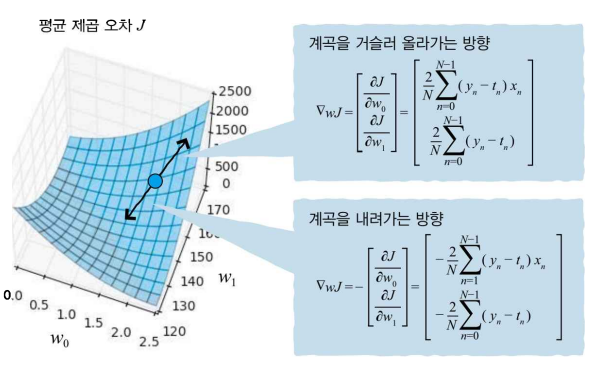

1. 초기 위치로 적당한 $w_0$, $w_1$ 결정
2. $J$ 지형 위 한 지점에 대응 후 기울기 확인, $J$가 가장 감소하는 방향으로 $w_0$과 $w_1$ 조금만 진행
3. 해당 절차 여러 번 반복

- $(w_0, w_1)$을 기준으로 언덕의 위쪽
    - $J$를 $w_0$과 $w_1$으로 편미분한 벡터 $[{\partial J \over \partial w_0}, {\partial J \over \partial w_1}]$
- 해당 수식을 $J$의 기울기, $\nabla \mathbf{w}J$로 나타냄
- $J$의 최소화 → 기울기의 반대 방향 $-\nabla \mathbf{w}J = -[{\partial J \over \partial w_0}, {\partial J \over \partial w_1}]^T $
- $\mathbf{w}$의 갱신 방법(학습 법칙)을 행렬 표기로 나타낼 시
$$ \mathbf{w}(t+1) = \mathbf{w}(t)-\alpha\nabla_wJ|_{\mathbf{w}(t)} $$

- $\nabla\mathbf{w}J$ -> $\mathbf{w}$의 함수
- $\mathbf{W}$에 현재의 $\mathbf{w}$ 값 $\mathbf{w}(t)$를 대입한 값 $\nabla_wJ|_{\mathbf{w}(t)}$ = $\mathbf{w}(t)$의 기울기
- $\alpha$ > 학습율 (양수값), $\mathbf{w}$ 갱신의 폭 조절
- 학습 법칙을 성분 표기로 나타낼 시
$$ w_0(t+1) = w_0(t)-\alpha{\partial J \over \partial w_0}|_{w_0(t), w_1(t)} $$

$$ w_1(t+1) = w_1(t)-\alpha{\partial J \over \partial w_0}|_{w_0(t), w_1(t)} $$

$$ J = {1 \over N} \sum_{n=0}^{N-1}(y_n-t_n)^2 = {1 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)^2 $$

$$ {\partial J \over \partial w_0} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)x_n = {2 \over N}\sum_{n=0}^{N-1}(y_n-t_n)x_n $$

$$ {\partial J \over \partial w_1} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n) = {2 \over N}\sum_{n=0}^{N-1}(y_n-t_n) $$

$$ w_0(t+1) = w_0(t)-\alpha{2 \over N}\sum_{n=0}^{N-1}(y_n-t_n)x_n $$

$$ w_1(t+1) = w_1(t)-\alpha{2 \over N}\sum_{n=0}^{N-1}(y_n-t_n) $$

In [20]:
# 평균 제곱 오차의 기울기
def dmse_line(x, t, w):
    y = w[0] * x + w[1]
    d_w0 = 2 * np.mean((y-t) * x)
    d_w1 = 2 * np.mean(y-t)
    return d_w0, d_w1

d_w = dmse_line(X, T, [10, 165])
print(np.round(d_w, 1))

[5046.3  301.8]


반복 횟수 13820
W=[1.539947, 136.176160]
dMSE=[-0.005794, 0.099991]
MSE=49.027452


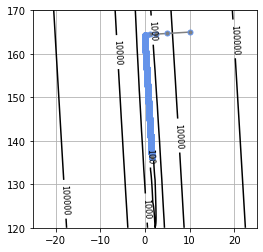

In [23]:
# 경사 하강법
def fit_line_num(x, t):
    w_init = [10.0, 165.0] # 초기 매개 변수
    alpha = 0.001 # 학습률
    i_max = 100000
    eps = 0.1 # 엡실론 (이 정도의 값에 다다르면 0으로 취급하고 학습을 종료하겠음)
    w_i = np.zeros([i_max, 2])
    w_i[0, :] = w_init
    for i in range(1, i_max):
        dmse = dmse_line(x, t, w_i[i-1])
        w_i[i, 0] = w_i[i-1, 0] - alpha * dmse[0]
        w_i[i, 1] = w_i[i-1, 1] - alpha * dmse[1]
        if max(np.absolute(dmse)) < eps: # 종료 판정
            break

    w0 = w_i[i, 0]
    w1 = w_i[i, 1]
    w_i = w_i[:i, :]
    return w0, w1, dmse, w_i

# 메인
plt.figure(figsize=(4, 4)) #MSE 등고선 표시
xn = 100 # 등고선 해상도
w0_range = [-25, 25]
w1_range = [120, 170]
x0 = np.linspace(w0_range[0], w0_range[1], xn)
x1 = np.linspace(w1_range[0], w1_range[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
J = np.zeros((len(x0), len(x1)))
for i0 in range(xn):
    for i1 in range(xn):
        J[i1, i0] = mse_line(X, T, (x0[i0], x1[i1]))
cont = plt.contour(xx0, xx1, J, 30, colors="black", levels=(100, 1000, 10000, 100000))
cont.clabel(fmt="%1.0f", fontsize=8)
plt.grid(True)

# 경사 하강법 호출
W0, W1, dMSE, W_history = fit_line_num(X, T)
# 결과 보기
print("반복 횟수 {}".format(W_history.shape[0]))
print("W=[{0:.6f}, {1:.6f}]".format(W0, W1))
print("dMSE=[{0:.6f}, {1:.6f}]".format(dMSE[0], dMSE[1]))
print("MSE={0:.6f}".format(mse_line(X, T, [W0, W1])))
plt.plot(W_history[:, 0], W_history[:, 1], ".-", color="gray", markersize=10, markeredgecolor="cornflowerblue")
plt.show()

w0=1.540, w1 = 136.176
SD=7.002 cm


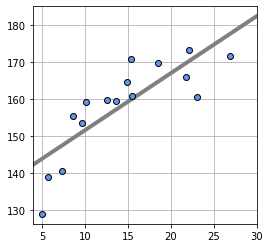

In [24]:
# 선 표시,
def show_line(w):
    xb = np.linspace(X_min, X_max, 200)
    y = w[0] * xb + w[1]
    plt.plot(xb, y, color=(.5, .5, .5), linewidth=4)
       
# 메인
plt.figure(figsize=(4, 4))
W = np.array([W0, W1])
mse = mse_line(X, T, W)
print("w0={0:.3f}, w1 = {1:.3f}".format(W0, W1))
print("SD={0:.3f} cm".format(np.sqrt(mse)))
show_line(W)
plt.plot(X, T, marker="o", linestyle="None", color="cornflowerblue", markeredgecolor="black")
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

- 일반적으로 경사 하강법으로 구해지는 해: 극솟값(O) 전체의 최솟값(X)
- 여기에서 다루는 $J$는 $w_0$과 $w_1$의 2차 함수로 되어 있음 > $J$는 함몰이 하나뿐인 그릇형이 보장

### 5.1.4 선형 모델 매개 변수의 해석해
- 수치해: 반복 계산에 의해 근사값을 구함
- 해석해: 방정식을 사용해 정확한 해를 구하기

$$ {\partial J \over \partial w_0} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)x_n=0 $$

$$ {\partial J \over \partial w_1} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)=0 $$

$$ {1 \over N}\sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)x_n = 0 $$

$$ {1 \over N}\sum_{n=0}^{N=1}w_0x_n^2 + {1 \over N}\sum_{n=0}^{N-1}w_1x_n - {1 \over N}\sum_{n=0}^{N-1}t_nx_n = 0 $$

$$ w_0{1 \over N}\sum_{n=0}^{N-1}x_n^2 + w_1{1 \over N}\sum_{n=0}^{N-1}x_n-{1 \over N}\sum_{n=0}^{N-1}t_nx_n=0 $$

$$ <x^2> = {1 \over N}\sum_{n=0}^{N-1}x_n^2, \quad <x>={1 \over N}\sum_{n=0}^{N-1}x_n, \quad <tx>={1 \over N}\sum_{n=0}^{N-1}t_nx_n $$

$$ w_0<x^2>+w_1<x> - <tx> = 0$$

$$ w_0<x> + w_1-<t> =0 \quad (<t>={1 \over N}\sum_{n=0}^{N-1}t_n) $$

$$ w_1=<t>-w_0<x> $$

$$ w_0 = {<tx>-<t><x> \over <x^2>-<x>^2} $$

$$ w_1 = <t>-w_0<x> = <t>-{<tx>-<t><x> \over <x^2>-<x>^2}<x> $$

w0=1.558, w1 = 135.872
SD=7.001 cm


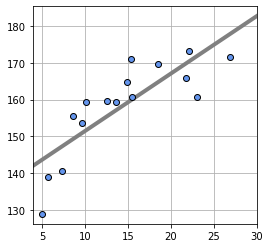

In [25]:
# 해석해
def fit_line(x, t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t*x)
    mxx = np.mean(x*x)
    w0 = (mtx - mt*mx) / (mxx - mx**2)
    w1 = mt - w0*mx
    return np.array([w0, w1])

#메인
W = fit_line(X, T)
print("w0={0:.3f}, w1 = {1:.3f}".format(W[0], W[1]))
mse = mse_line(X, T, W)
print("SD={0:.3f} cm".format(np.sqrt(mse)))
plt.figure(figsize=(4, 4))
show_line(W)
plt.plot(X, T, marker="o", linestyle="None", color="cornflowerblue", markeredgecolor="black")
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

## 5.2 2차원 입력면 모델
- 입력이 2차원 > $\mathbf{x}=(x_0, x_1)$에 확장

In [26]:
# 2차원 데이터 생성
X0 = X
X0_min = 5
X0_max = 30
np.random.seed(seed=1) # 난수 고정
X1 = 23*(T/100)**2 + 2*np.random.randn(X_n)
X1_min = 40
X1_max = 75

print(np.round(X0, 2))
print(np.round(X1, 2))
print(np.round(T, 2))

[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
[70.43 58.15 37.22 56.51 57.32 40.84 57.79 56.94 63.03 65.69 62.33 64.95
 57.73 66.89 46.68 61.08]
[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


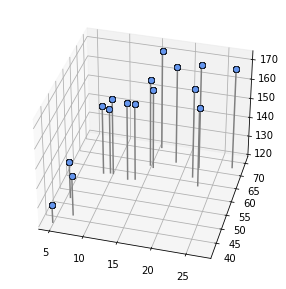

In [29]:
# 2차원 데이터 표시
def show_data2(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot([x0[i], x0[i]], [x1[i], x1[i]], [120, t[i]], color="gray")
        ax.plot(x0, x1, t, "o", color="cornflowerblue", markeredgecolor="black", markersize=6, markeredgewidth=0.5)
        ax.view_init(elev=35, azim=-75)
        
# 메인
plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection="3d")
show_data2(ax, X0, X1, T)
plt.show()

### 5.2.1 데이터의 표시 방법
$$ \mathbf{x}_n = [x_{n, 0}, x_{n, 1}] $$
$x_n$이 2차원이 아닌 $M$차원이라면
$$ \mathbf{x}_n = [x_{n, 0}, x_{n, 1}, \cdots, x_{n, M-1}] $$
모든 데이터 $n$을 보여주는 경우

$$ \mathbf{X} = \left[\begin{matrix} x_{0, 0} & x_{0, 1} & \cdots & x_{0, M-1} \\ x_{1, 0} & x_{1, 1} & \cdots & x_{1, M-1} \\ \vdots & \vdots & \ddots & \vdots \\ x_{N-1, 0} & x_{N-1, 1} & \cdots & x_{N-1, M-1} \end{matrix}\right]$$
차원 $m$으로 정리하고 싶을 경우
$$ \mathbf{x}_m = \left[\begin{matrix} x_{0, m} \\ x_{1, m} \\ \vdots \\ x_{N-1, m} \end{matrix}\right]$$
$t$에 대해서도 모든 $N$으로 정리할 때
$$ \mathbf{t} = \left[\begin{matrix} t_0 \\ t_1 \\ \vdots \\ t_{N-1} \end{matrix}\right]$$

### 5.2.2 면 모델

SD=12.876 cm


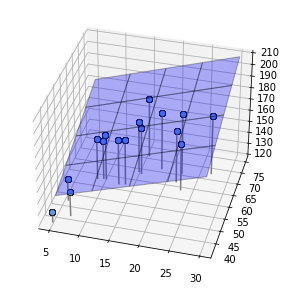

In [30]:
# 면 표시
def show_plane(ax, w):
    px0 = np.linspace(X0_min, X0_max, 5)
    px1 = np.linspace(X1_min, X1_max, 5)
    px0, px1 = np.meshgrid(px0, px1)
    y = w[0]*px0 + w[1]*px1 + w[2]
    ax.plot_surface(px0, px1, y, rstride=1, cstride=1, alpha=0.3, color="blue", edgecolor="black")
    
# 면의 MSE
def mse_plane(x0, x1, t, w):
    y = w[0] * x0 + w[1] * x1 + w[2] # (A)
    mse = np.mean((y-t)**2)
    return mse

# 메인
plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection="3d")
W = [1.5, 1, 90]
show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
print("SD={0:.3f} cm".format(np.sqrt(mse)))
plt.show()

- 면의 함수는 아래와 같이 표시
$$ y(x) = w_0x_0 + w_1x_1 + w_2 $$

### 5.2.3 매개 변수의 해석해
- 2차원 면 모델에서의 평균 제곱 오차 정의
$$ J = {1 \over N}\sum_{n=0}^{N-1}(y(x_n)-t_n)^2 = {1 \over N}\sum_{n=0}^{N-1}(w_0x_{n, 0}+w_1x_{n, 1}+w_2-t_n)^2 $$

- $J$가 가장 작아지는 $\mathbf{w} = [w_0, w_1, w_2]$

$$ {\partial J \over \partial w_0} = 0, \quad {\partial J \over \partial w_1} = 0, \quad {\partial J \over \partial w_2} = 0 $$

$$ {\partial J \over \partial w_0} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_{n, 0}+w_1x_{n, 1}+w_2-t_n)x_{n, 0} = 2\{w_0<x_0^2>+w_1<x_0x_1>+w_2<x>-<tx_0>\}=0 $$
$$ {\partial J \over \partial w_1} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_{n, 0}+w_1x_{n, 1}+w_2-t_n)x_{n, 1} = 2\{w_0<x_0^2>+w_1<x_1^2>+w_2<x>-<tx_1>\}=0 $$
$$ {\partial J \over \partial w_2} = {2 \over N}\sum_{n=0}^{N-1}(w_0x_{n, 0}+w_1x_{n, 1}+w_2-t_n) = 2\{w_0<x_0>+w_1<x_1>+w_2-<t>\}=0 $$

- 3개의 연립 방정식을 풀면

$\newcommand{\e}{\mathrm{E}}$
$\newcommand{\var}{\mathrm{var}}$
$\newcommand{\cov}{\mathrm{cov}}$

$$ w_0 = {\cov(t, x_1)\cov(x_0, x_1)-\var(x_1)\cov(t, x_0) \over \cov(x_0, x_1)^2-\var(x_0)\var(x_1)} $$

$$ w_1 = {\cov(t, x_0)\cov(x_0, x_1)-\var(x_0)\cov(t, x_1) \over \cov(x_0, x_1)^2-\var(x_0)\var(x_1)} $$

$$ w_2 = -w_0<x_0>-w_1<x_1>+<t> $$

$a$의 분산 ($a$와 얼마나 차이가 있는가): $\var(a) = <a^2>-<a>^2$ <br>
$a$와 $b$의 공분산 ($a$와 $b$가 얼마나 영향을 끼치고 있는가): $\cov(a, b)=<ab>-<a><b>$

w0=0.5, w1=1.1, w2=89.0
SD=2.546 cm


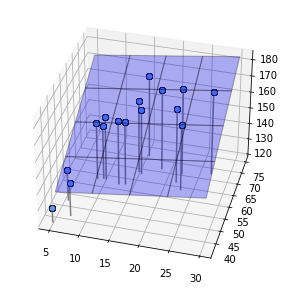

In [33]:
# 해석해
def fit_plane(x0, x1, t):
    c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
    c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
    c_x0x1 = np.mean(x0 * x1) - np.mean(x0) * np.mean(x1)
    v_x0 = np.var(x0)
    v_x1 = np.var(x1)
    w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1**2 - v_x0 * v_x1)
    w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1**2 - v_x0 * v_x1)
    w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
    return np.array([w0, w1, w2]) 


# 메인
plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
W = fit_plane(X0, X1, T)
print("w0={0:.1f}, w1={1:.1f}, w2={2:.1f}".format(W[0], W[1], W[2]))
show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
print("SD={0:.3f} cm".format(np.sqrt(mse)))
plt.show()

## 5.3 D차원 선형 회귀 모델
### 5.3.1 D차원 선형 회귀 모델

- 직선 모델(1차원 입력), 면 모델(2차원 입력) > 선형 회귀 모델
- 일반적으로 다음과 같이 표시
$$ y(x) = w_0x_0 + w_1x_1 + \cdots + w_{D-1}x_{D-1} + w_D $$

- $w_D$는 절편 ($x$가 곱해지지 않음)
- 절편 X > 어떤 $\mathbf{w}$더라도 원점을 지나는 평면
- 행렬 표기법을 사용하여 정리 시
$$ y(x) = w_0x_0 + w_1x_1 + \cdots + w_{D-1}x_{D-1} = [w_0 \cdots w_{D-1}][x_0 \cdots x_{D-1}]^T = \mathbf{w}^T\mathbf{x} $$
$$ \mathbf{w}^T = [ w_0 \cdots w_{D-1}] $$

### 5.3.2 매개 변수의 해석해
- 평균 제곱 오차 $J$
$$ J(\mathbf{w}) = {1 \over N}\sum_{n=0}^{N-1}(y(x_n)-t_n)^2={1 \over N}\sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n-t_n)^2 $$
- 연쇄 법칙을 사용해서 $w_i$로 미분 시
$$ {\partial J \over \partial w_i} = {1 \over N}\sum_{n=0}^{N-1}{\partial \over \partial w_i}(\mathbf{w}^T\mathbf{x}_n-t_n)^2 = {2 \over N} \sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n-t_n)x_{n, i} $$

- $J$를 최소로 만드는 $\mathbf{w}$는 모든 $w_i$ 방향에 대해 기울기 0 (위의 식) > $i=0~D-1$에서 아래의 식 성립

$$ {2 \over N}\sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n-t_n)x_{n, i}=0 $$

- $D$개의 연립 방정식을 각 $W_i$에 대해 풀면 해답 얻기 가능

$$ \sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n-t_n)x_{n, i} = 0 $$

$$ \sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n-t_n)[x_{n, 0}, x_{n, 1}, \cdots, x_{x, D-1}] = [0 \, 0 \, \cdots \, 0]$$

$$ \sum_{n=0}^{N-1}(\mathbf{w}^T\mathbf{x}_n\mathbf{x}_n^T-t_n\mathbf{x}_n^T) = [0 \, 0 \, \cdots \, 0] $$

$$ \mathbf{w}^T\sum_{n=0}^{N-1}\mathbf{x}_n\mathbf{x}_n^T - \sum_{n=0}^{N-1}t_n\mathbf{x}_n^T = [0 \, 0 \, \cdots \, 0] $$

위의 수식에
$$ \sum_{n=0}^{N-1}\mathbf{x}_n\mathbf{x}_n^T = \mathbf{X}^T\mathbf{X} $$
$$ \sum_{n=0}^{N-1}t_n\mathbf{x}_n^T = \mathbf{t}^T\mathbf{X} $$
다음을 대입하여 아래의 수식으로 변환

$$ \mathbf{w}^T\mathbf{X}^T\mathbf{X} - \mathbf{t}^T\mathbf{X} = [0 \, 0 \, \cdots \, 0] $$

$$ \mathbf{X} = \left[\begin{matrix} x_{0, 0} & x_{0, 1} & \cdots & x_{0, D-1} \\ x_{1, 0} & x_{1, 1} & \cdots & x_{1, D-1} \\ \vdots & \vdots & \ddots & \vdots \\ x_{N-1, 0} & x_{N-1, 1} & \cdots & x_{N-1, D-1} \end{matrix}\right]$$

$\mathbf{X}^T\mathbf{X}$를 성분 표기 시

$$ \left[\begin{matrix} \sum_{n=0}^{N-1}x_{n, 0}^2 & \sum_{n=0}^{N-1}x_{n, 0}x_{n, 1} & \cdots & \sum_{n=0}^{N-1}x_{n, 0}x_{n, D-1} \\ \sum_{n=0}^{N-1}x_{n, 1}x_{n, 0} & \sum_{n=0}^{N-1}x_{n, 1}^2 & \cdots & \sum_{n=0}^{N-1}x_{n, 1}x_{n, D-1} \\ \vdots & \vdots & \ddots & \vdots \\ \sum_{n=0}^{N-1}x_{n, D-1}x_{n, 0} & \sum_{n=0}^{N-1}x_{n, D-1}x_{n, 1} & \cdots & \sum_{n=0}^{N-1}x_{n, D-1}^2 \end{matrix}\right]$$

$\mathbf{t}^T\mathbf{X}$를 성분 표기 시

$$ [\sum_{n=0}^{N-1}t_nx_{n, 0} \quad \sum_{n=0}^{N-1}t_nx_{n, 1} \quad \sum_{n=0}^{N-1}t_nx_{n, D-1}] $$

$$ (\mathbf{w}^T\mathbf{X}^T\mathbf{X} - \mathbf{t}^T\mathbf{X})^T = [0 \, 0 \, \cdots \, 0]^T $$

$$ (\mathbf{w}^T\mathbf{X}^T\mathbf{X})^T - (\mathbf{t}^T\mathbf{X})^T = [0 \, 0 \, \cdots \, 0]^T $$

$$ (\mathbf{X}^T\mathbf{X})^T(\mathbf{w}^T)^T - \mathbf{X}^T\mathbf{t} = [0 \, 0 \, \cdots \, 0]^T $$

$$ (\mathbf{X}^T\mathbf{X})\mathbf{w} - \mathbf{X}^T\mathbf{t} = [0 \, 0 \, \cdots \, 0]^T $$

$$ (\mathbf{X}^T\mathbf{X})\mathbf{w} = \mathbf{X}^T\mathbf{t} $$

$$ \mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t} $$

### 5.3.3 원점을 지나지 않는 면에 대한 확장

- 원점에 고정된 면의 방정식 (입력 데이터 2차원일 시)
$$ y(x) = w_0x_0 + w_1x_1 $$
- 원점을 지나지 않는 면
$$ y(x) = w_0x_0 + w_1x_1 + w_2 $$

- $\mathbf{x}$ 2차원 벡터 > 3차원 요소 $x_2=1$ 추가

$$ y(x) = w_0x_0 + w_1x_1 + w_2x_2 = w_0x_0 + w_1x_1 + w_2 $$

- $D$차원의 $x$에서도 $D+1$번째 차원에 1을 얻는 요소 추가 시 > 자유롭게 움직이는 모델 표현 가능

## 5.4 선형 기저 함수 모델
- 가우스 기저 함수
$$ \Phi_j(x) = \exp \{-{(x-\mu_j)^2 \over 2s^2}\} $$

- 가우스 함수의 중심 $\mu_j$ (모델의 설계자가 결정하는 매개 변수)
- 함수 확장 정도 $s$ (설계자가 결정하는 매개 변수)
- $s$는 모든 가우스 함수의 공통 매개 변수

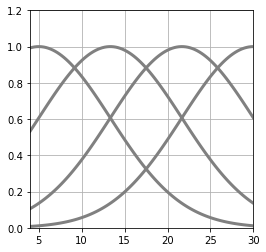

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 로드
outfile = np.load('ch5_data.npz')
X = outfile['X']
X_min = outfile['X_min']
X_max = outfile['X_max']
X_n = outfile['X_n']
T = outfile['T']

# 가우스 함수
def gauss(x, mu, s):
    return np.exp(-(x - mu)**2 / (2 * s**2))

# 메인
M = 4
plt.figure(figsize=(4, 4))
mu = np.linspace(5, 30, M)
s = mu[1] - mu[0] # (A) s는 인접한 가우스 함수 중심 사이 거리
xb = np.linspace(X_min, X_max, 100)
for j in range(M):
    y = gauss(xb, mu[j], s)
    plt.plot(xb, y, color='gray', linewidth=3)
plt.grid(True)
plt.xlim(X_min, X_max)
plt.ylim(0, 1.2)
plt.show()

- $M=4$의 선형 기저 함수 모델
$$ y(x, \mathbf{w} = w_0\phi_0(x)+w_1\phi_1(x) + w_2\phi_w(x) + w_3\phi_3(x) + w_4 $$

- 매개변수 $\mathbf{w}$ 가중치 매개 변수
- $w_4$ 곡선 상하의 평행 이동 조절 > 항상 1을 출력하는 $\phi_4(x)=1$ 더미 기초 함수 추가 가능
- 다음과 같이 표현
$$ y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^Mw_j\phi_j(\mathbf{x}) = \mathbf{w}^T\Phi(\mathbf(x)) $$

- 평균 제곱 오차 $J$
$$ J(\mathbf{w}) = {1 \over N}\sum_{n=0}^{N-1}\{\mathbf{w}^T\phi(x_n)-t_n\}^2 $$

- 선형 모델의 평균 제곱 오차
$$ J(\mathbf{w}) = {1 \over N}\sum_{n=0}^{N-1}\{\mathbf{w}^T\mathbf{x}_n-t_n\}^2 $$

- 선형 기저 함수 모델의 해석
    - '전처리'로, 1차원 데이터 $\mathbf{x}_n$을 $M$차원의 데이터 벡터 $x_n=\Phi(x_n)$으로 변환
    - $M$차원 입력 $x_n$에 대해 선형 회귀 모델 적용

$J$를 최소화하는 매개 변수 $\mathbf{w}$는 위의 해석해
$$ \mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t} $$
의 $X$를 $\Phi$로 대체한 다음의 식으로 표현 가능
$$ \mathbf{w} = (\Phi^T\Phi)^{-1}\Phi^T\mathbf{t} $$

W=[29.4 75.7  2.9 98.3 54.9]
SD=3.98 cm


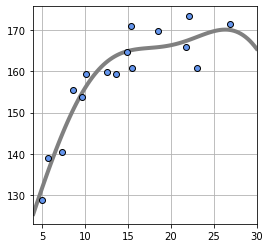

In [36]:
# 선형 기저 함수 모델
def gauss_func(w, x):
    m = len(w) - 1
    mu = np.linspace(5, 30, m)
    s = mu[1] - mu[0]
    y = np.zeros_like(x) # x와 같은 크기로 요소가 0인 행렬 y 작성
    for j in range(m):
        y = y + w[j] * gauss(x, mu[j], s)
    y = y + w[m]
    return y

# 선형 기저 함수 모델 MSE
def mse_gauss_func(x, t, w):
    y = gauss_func(w, x)
    mse = np.mean((y-t)**2)
    return mse

# 선형 기저 함수 모델 정확한 해
def fit_gauss_func(x, t, m):
    mu = np.linspace(5, 30, m)
    s = mu[1] - mu[0]
    n = x.shape[0]
    psi = np.ones((n, m+1))
    for j in range(m):
        psi[:, j] = gauss(x, mu[j], s)
    psi_T = np.transpose(psi)
    
    b = np.linalg.inv(psi_T.dot(psi))
    c = b.dot(psi_T)
    w = c.dot(t)
    return w

# 가우스 기저 함수 표시
def show_gauss_func(w):
    xb = np.linspace(X_min, X_max, 100)
    y = gauss_func(w, xb)
    plt.plot(xb, y, c=[.5, .5, .5], lw = 4)
    
# 메인
plt.figure(figsize=(4, 4))
M = 4
W = fit_gauss_func(X, T, M)
show_gauss_func(W)
plt.plot(X, T, marker="o", linestyle="None", color="cornflowerblue", markeredgecolor="black")
plt.xlim(X_min, X_max)
plt.grid(True)
mse = mse_gauss_func(X, T, W)
print("W="+ str(np.round(W, 1)))
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

## 5.5 오버피팅의 문제

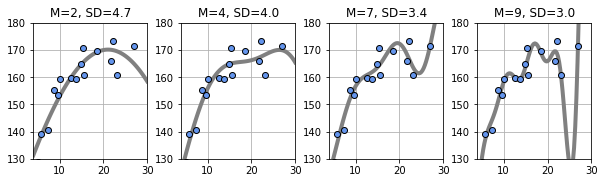

In [40]:
plt.figure(figsize=(10, 2.5))
plt.subplots_adjust(wspace=0.3)
M = [2, 4, 7, 9]

for i in range(len(M)):
    plt.subplot(1, len(M), i + 1)
    W = fit_gauss_func(X, T, M[i])
    show_gauss_func(W)
    plt.plot(X, T, marker='o', linestyle='None',
             color='cornflowerblue', markeredgecolor='black')
    plt.xlim(X_min, X_max)
    plt.grid(True)
    plt.ylim(130, 180)
    mse = mse_gauss_func(X, T, W)
    
    
    plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))
    
plt.show()

- $M$의 증가에 따라 SD 줄어드는 것 확인 가능

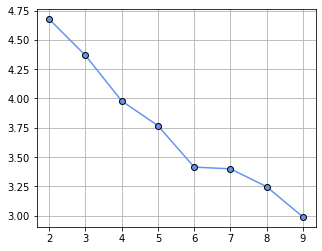

In [41]:
plt.figure(figsize=(5, 4))
M = range(2, 10)
mse2 = np.zeros(len(M))
for i in range(len(M)):
    W = fit_gauss_func(X, T, M[i])
    mse2[i] = np.sqrt(mse_gauss_func(X, T, W))
plt.plot(M, mse2, marker="o", color="cornflowerblue", markeredgecolor="black")
plt.grid(True)
plt.show()

- $M$이 증가할수록 곡선은 데이터 점에 근접, 오차(SD)는 감소
- 데이터 점이 없는 곳은 평균 제곱 오차와 관계 X
- overfitting 발생

- 훈련 데이터의 평균 제곱 오차를 최소화하도록 매개 변수 $\mathbf{w}$ 선택
- 훈련에 이용되지 않은 미지의 데이터에 대한 예측 오차로 $M$ 평가
- 홀드아웃 검증

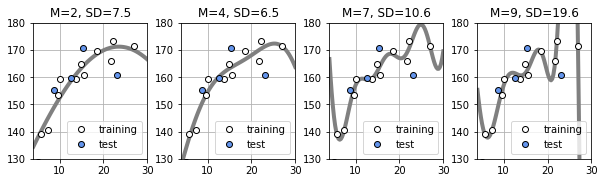

In [49]:
# 훈련 데이터와 테스트 데이터
X_test = X[:int(X_n / 4 + 1)]
T_test = T[:int(X_n / 4 + 1)]
X_train = X[int(X_n / 4 + 1):]
T_train = T[int(X_n / 4 + 1):]

# 메인
plt.figure(figsize=(10, 2.5))
plt.subplots_adjust(wspace=0.3)
M = [2, 4, 7, 9]
for i in range(len(M)):
    plt.subplot(1, len(M), i + 1)
    W = fit_gauss_func(X_train, T_train, M[i])
    show_gauss_func(W)
    plt.plot(X_train, T_train, marker='o',
             linestyle='None', color='white',
             markeredgecolor='black', label='training')
    plt.plot(X_test, T_test, marker='o', linestyle='None',
             color='cornflowerblue',
             markeredgecolor='black', label='test')
    plt.legend(loc='lower right', fontsize=10, numpoints=1)
    plt.xlim(X_min, X_max)
    plt.ylim(130, 180)
    plt.grid(True)
    mse = mse_gauss_func(X_test, T_test, W)
    plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))

plt.show()

- 피팅에 사용하지 않는 테스트 데이터(파란 점)에서 점점 벗어나는 중

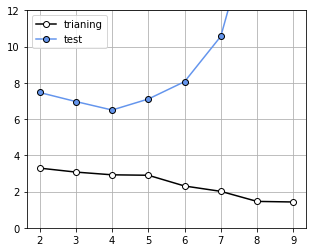

In [50]:
plt.figure(figsize=(5, 4))
M = range(2, 10)
mse_train = np.zeros(len(M))
mse_test = np.zeros(len(M))
for i in range(len(M)):
    W = fit_gauss_func(X_train, T_train, M[i])
    mse_train[i] = np.sqrt(mse_gauss_func(X_train, T_train, W))
    mse_test[i] = np.sqrt(mse_gauss_func(X_test, T_test, W))
plt.plot(M, mse_train, marker="o", linestyle="-", markerfacecolor="white", markeredgecolor="black", color="black", label="trianing")
plt.plot(M, mse_test, marker="o", linestyle="-", color="cornflowerblue", markeredgecolor="black", label="test")
plt.legend(loc="upper left", fontsize=10)
plt.ylim(0, 12)
plt.grid(True)
plt.show()

$M=5$에서 오버피팅이 일어나고 있음 > $M=4$가 해당 데이터에 가장 적합

- K fold cross validation 방법
    - 다양한 분할에서 오차를 내고 평균을 계산하자
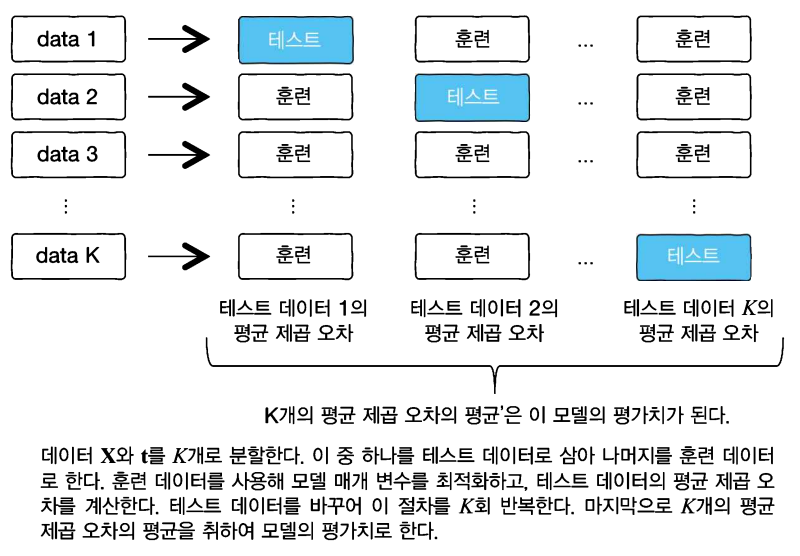

- 데이터 $X$와 $\mathbf{t}$를 $K$개로 분할
1. 첫 번째 데이터를 테스트 데이터로, 나머지를 훈련 데이터로
2. 훈련 데이터로부터 모델 $M$의 매개 변수를 구하고, 해당 매개 변수를 사용해서 테스트 데이터에서 평균 제곱 오차 계산
3. 위의 절차를 $K$회 반복
4. $K$개의 평균 제곱 오차의 평균 계산 > $M$의 평가값으로 함
- 최대 분할 수: $K=N$ (테스트 데이터 크기 1, LOOCV라고 함, 데이터가 적을 경우 사용)

In [57]:
# K겹 교차 검증
def kfold_gauss_func(x, t, m, k):
    n = x.shape[0]
    mse_train = np.zeros(k)
    mse_test = np.zeros(k)
    for i in range(0, k):
        x_train = x[np.fmod(range(n), k) != i] # (A)
        t_train = t[np.fmod(range(n), k) != i] # (A)
        x_test = x[np.fmod(range(n), k) == i] # (A)
        t_test = t[np.fmod(range(n), k) == i] # (A)
        wm = fit_gauss_func(x_train, t_train, m)
        mse_train[i] = mse_gauss_func(x_train, t_train, wm)
        mse_test[i] = mse_gauss_func(x_test, t_test, wm)
    return mse_train, mse_test

- np.fmod(n, k): n을 k로 나눈 나머지를 출력

In [52]:
np.fmod(range(10), 5)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4], dtype=int32)

In [53]:
M = 4
K = 4
kfold_gauss_func(X, T, M, K)

(array([12.87927851,  9.81768697, 17.2615696 , 12.92270498]),
 array([12.87927851,  9.81768697, 17.2615696 , 12.92270498]))

- 위쪽이 훈련 데이터의 평균 제곱 오차
- 아랫쪽이 테스트 데이터에서 평균 제곱 오차

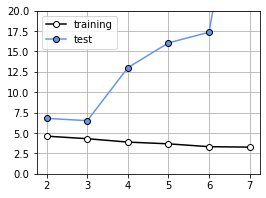

In [58]:
M = range(2, 8)
K = 16
Cv_Gauss_train = np.zeros((K, len(M)))
Cv_Gauss_test = np.zeros((K, len(M)))
for i in range(0, len(M)):
    Cv_Gauss_train[:, i], Cv_Gauss_test[:, i] =\
                    kfold_gauss_func(X, T, M[i], K)
mean_Gauss_train = np.sqrt(np.mean(Cv_Gauss_train, axis=0))
mean_Gauss_test = np.sqrt(np.mean(Cv_Gauss_test, axis=0))


plt.figure(figsize=(4, 3))
plt.plot(M, mean_Gauss_train, marker='o', linestyle='-',
         color='k', markerfacecolor='w', label='training')
plt.plot(M, mean_Gauss_test, marker='o', linestyle='-',
         color='cornflowerblue', markeredgecolor='black', label='test')
plt.legend(loc='upper left', fontsize=10)
plt.ylim(0, 20)
plt.grid(True)
plt.show()

- $M=3$일 때 테스트 데이터의 오차가 가장 작음
- LOOCV에서는 $M=3$이 가장 적합함
- 교차 검증: $M$을 구하기 위한 방법 (모델 매개 변수 $\mathbf{w}$를 구하는 용도 X)
- $M=3$과 모든 데이터를 사용해서 매개 변수 $\mathbf{w}$를 마지막으로 계산

SD=4.37 cm


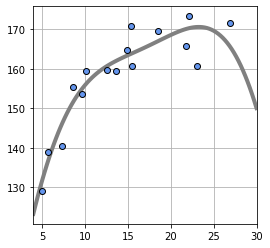

In [60]:
M = 3
plt.figure(figsize=(4, 4))
W = fit_gauss_func(X, T, M)
show_gauss_func(W)
plt.plot(X, T, marker='o', linestyle='None',
         color='cornflowerblue', markeredgecolor='black')
plt.xlim([X_min, X_max])
plt.grid(True)
mse = mse_gauss_func(X, T, W)
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

- LOOCV에서 얻은 $M=3$의 선형 기저 함수 모델 피팅
- 데이터 수가 적으면 교차 검증이 유용
- 데이터 수가 많으면 교차 검증 시간 ↑ 홀드 아웃 검증 사용 (교차 검증과 비슷한 결과)

## 5.6 새로운 모델의 생성

나이 $x$가 증가함에 따라 키가 점차 증가하다가 결국에는 일정한 값으로 수렴하는 함수
$$ y(x) = w_0 - w_1 \exp(-w_2x) $$

평균 제곱 오차 $J$가 최소가 되도록 $w_0, w_1, w_2$를 선택

In [61]:
# 모델 A
def model_A(x, w):
    y = w[0] - w[1] * np.exp(-w[2] * x)
    return y 


# 모델 A 표시
def show_model_A(w):
    xb = np.linspace(X_min, X_max, 100)
    y = model_A(xb, w)
    plt.plot(xb, y, c=[.5, .5, .5], lw=4) 


# 모델 A의 MSE
def mse_model_A(w, x, t):
    y = model_A(x, w)
    mse = np.mean((y - t)**2)
    return mse

In [62]:
from scipy.optimize import minimize 

# 모델 A의 매개 변수 최적화
def fit_model_A(w_init, x, t):
    res1 = minimize(mse_model_A, w_init, args=(x, t), method="powell")
    return res1.x

- 구배를 사용하지 않는 최적화 방법인 파웰 알고리즘 지정
    - 파웰 알고리즘: 최소화 함수를 사용할 때 늦게 수렴되거나 수렴이 보장되지 않는 경우 실험적으로 사용

w0=169.0, w1=113.7, w2=0.2
SD=3.86 cm


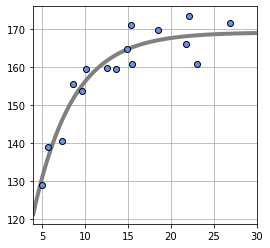

In [63]:
# 메인
plt.figure(figsize=(4, 4))
W_init=[100, 0, 0]
W = fit_model_A(W_init, X, T)
print("w0={0:.1f}, w1={1:.1f}, w2={2:.1f}".format(W[0], W[1], W[2]))
show_model_A(W)
plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue',markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
mse = mse_model_A(W, X, T)
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

## 5.7 모델의 선택

- 어느 모델이 좋은지 판단하기 위해
- 미지의 데이터에 대한 예측 정확도로 평가함 > 홀드 아웃 검증&교차 검증 모델로 평가 가능

Gauss(M=3) SD=6.51 cm
Model A SD=4.72 cm


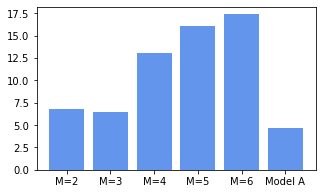

In [64]:
# 교차 검증 model_A
def kfold_model_A(x, t, k):
    n = len(x)
    mse_train = np.zeros(k)
    mse_test = np.zeros(k)
    for i in range(0, k):
        x_train = x[np.fmod(range(n), k) != i]
        t_train = t[np.fmod(range(n), k) != i]
        x_test = x[np.fmod(range(n), k) == i]
        t_test = t[np.fmod(range(n), k) == i]
        wm = fit_model_A(np.array([169, 113, 0.2]), x_train, t_train)
        mse_train[i] = mse_model_A(wm, x_train, t_train)
        mse_test[i] = mse_model_A(wm, x_test, t_test)
    return mse_train, mse_test


# 메인
K = 16
Cv_A_train, Cv_A_test = kfold_model_A(X, T, K)
mean_A_test = np.sqrt(np.mean(Cv_A_test))
print("Gauss(M=3) SD={0:.2f} cm".format(mean_Gauss_test[1]))
print("Model A SD={0:.2f} cm".format(mean_A_test))
SD = np.append(mean_Gauss_test[0:5], mean_A_test)
M = range(6)
label = ["M=2", "M=3", "M=4", "M=5", "M=6", "Model A"]
plt.figure(figsize=(5, 3))
plt.bar(M, SD, tick_label=label, align="center",
facecolor="cornflowerblue")
plt.show()

- 선형 기저 함수 모델보다 모델 A가 데이터에 잘 어울림

## 5.8 정리
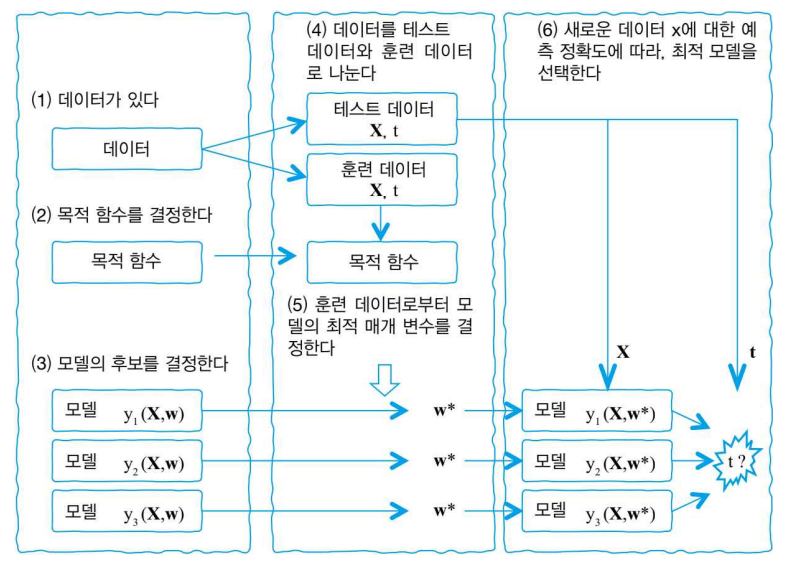

1. 입력 변수와 목표 변수의 데이터
    - 목표: 미지의 입력 변수에 대한 목표 변수 예측 모델 만들기
2. 무엇을 가지고 예측 정확도를 높일지 목적 함수 결정
    - 이번에는 평균 제곱 오차 함수 사용
    - 가능도(우도) 등도 가능
3. 모델 후보 결정
    - 선형 회귀 모델만으로 적절한지
    - 곡선 모델도 가능한지
    - 데이터의 특성을 안다면 이를 도입한 모델을 고안할 수 있는지
4. 테스트 데이터와 훈련 데이터로 나누기 (홀드 아웃 검증을 할 시)
5. 훈련 데이터를 사용하여 원하는 함수가 최소(최대)가 되도록 모델의 매개 변수 $\mathbf{w}^*$ 결정
6. 모델매개변수를 사용해서 테스트 데이터의 입력 데이터 $\mathbf{X}$에서 목표 데이터 $\mathbf{t}$의 예측을 실시하여 가장 오차가 적은 모델 선택 <br>
→ 최적화된 모델이 미지의 입력에 대해 가장 유력한 예측 모델임